# Demo Showcasing differential privacy 
Sepsis event log is used for this demo


In [1]:
import pandas as pd
import pretsa as sanatizeAlg
import matplotlib.pyplot as plt


# Loading and preprocessing the Sepsis event log

In [7]:
# eventlogURL = 'https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639'

eventlog = pd.read_csv('./Data/Sepsis.csv')

# The PRETSA algorithm requires certain column names to work properly. 
# These columns are hard coded in pretsa.py and can be changed if needed. 
eventlog.rename(columns={'time:timestamp':'Complete_Timestamp', 'concept:name':'Activity', 'case:concept:name':'Case_ID'}, inplace=True)
# write the event log to file 
Dataset = 'Sepsis'
filePath = "./Data/Sepsis.csv"
eventlog.to_csv(filePath, index=False)
print("Finished loading eventlog")

Finished loading eventlog


In [8]:
# Adding duration column to the event logs 
! python3 add_annotation_duration.py {Dataset} {filePath}
modifiedEventlog = pd.read_csv(filePath.replace(".csv",'_duration.csv'), delimiter=';')
modifiedEventlog

./Data/Sepsis_duration.csv
Duration notation added, Available at ./Data/Sepsis_duration.csv


,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Activity,...,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Case_ID,Leucocytes,CRP,LacticAcid,Duration
0,True,A,True,True,True,True,True,True,True,ER Registration,...,complete,A,False,True,True,A,NaN,NaN,NaN,0.000000
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN,0.007859
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN,0.000000
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2,0.000000
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,0.004595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN,0.000000
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN,0.416667
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,complete,NaN,False,False,False,LNA,NaN,NaN,NaN,0.000000
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN,0.002674


# Running PRETSA 


In [9]:
# Initializing the privacy parameters 
k = 10
t = 0.6
l = 1
# setting path for the sanitized eventlog 
targetFilePath = filePath.replace(".csv","_t%s_k%s_pretsa.csv" % (t,k))
print("Starting experiments")
# Instantiate the Pretsa class, creating the prefix tree as describe in the paper 
pretsa = sanatizeAlg.Pretsa(modifiedEventlog)
# Apply the algorithm to the event log with the given privacy parameters 
cutOutCases = pretsa.runPretsa(int(k),float(t), int(l))
print("Modified " + str(len(cutOutCases[0])) + " cases for k=" + str(k))
# Generate the anonymized eventlog from the tree
privateEventLog_noDP = pretsa.getPrivatisedEventLog(applydp=False)
print("Event log sanitization finished.")

Starting experiments
Generated Distance Matrix
Modified 852 cases for k=10
Event log sanitization finished.


# Testing the Differential privacy feature
##### By providing multiple epsilon values to the algorithm, we measure the mean of each query's annotation. Moreover, comparing it against the original solution, we showcase the effect of different epsilons. 

In [5]:
# Initialize a list of budget privacy values
epsilonlist = [0.05, 0.1, 0.3, 0.5, 1, 2, 3, 5, 10, 20]
privateEventlogs_DP = []
# generate different queries based on the epsilon list
for i, epsilon in enumerate(epsilonlist):
    privateEventlogs_DP.append(pretsa.getPrivatisedEventLog(applydp=True, epsilon=epsilonlist[i]))
# choosing one activity in the event log to measure the amount of noise added
testActivity = 'CRP'

noDP = privateEventLog_noDP.loc[privateEventLog_noDP['Activity'] == testActivity]['Duration']
averageNoiseAdded = []
# calculate the average noise added to the values of the CRP activity by subtracting it from the query with no differential privacy
for pel in privateEventlogs_DP:
    averageNoiseAdded.append((pel[pel['Activity'] == testActivity]['Duration'] - noDP).mean())

Differential privacy mechanism ready
Differential privacy applied to event log epsilon=0.05
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=0.1
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=0.3
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=0.5
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=1
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=2
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=3
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=5
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=10
Differential privacy mechanism ready
Differential privacy applied to event log epsilon=20


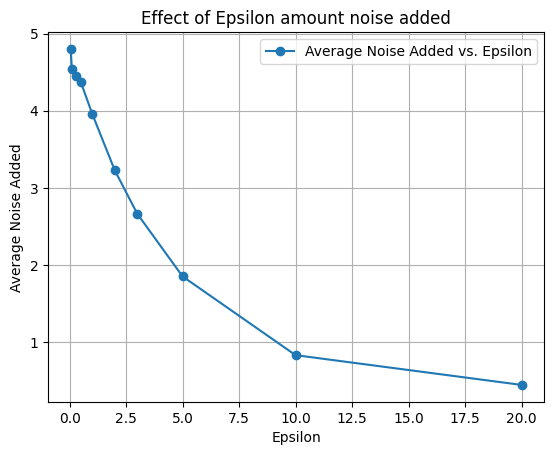

In [10]:
# Draw the plot showcasing the average noise added,
# Note: for this verification of results to be more accurate, running the query multiple times for each epsilon value and using the mean of them is a better approach.

plt.plot(epsilonlist, averageNoiseAdded, marker='o', label='Average Noise Added vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Average Noise Added')
plt.title('Effect of Epsilon amount noise added')
plt.legend()
plt.grid(True)
plt.show()


As seen, with increasing the budget privacy, the amount of noise added to the sensitive attribute is decreased. Therefore, the budget privacy provided determines the trade off between utility and security. 